### CNN 프로젝트

#### 주제

- 가위, 바위, 보 이미지 분류

#### 데이터 수집 링크

- kaggle: https://www.kaggle.com/datasets/drgfreeman/rockpaperscissors


#### 목차

1. 데이터(이미지) 탐색
2. 학습/검증/테스트 데이터(이미지) 분리 및 파일 처리
3. 사전 훈련 모델 학습 및 예측, 평가
    1) VGG16
    2) XCeption
    3) ResNet50
    4) MobileNetV2
4. 모델별 예측 정확도 비교
5. 실제 이미지에 대한 예측 수행
6. 느낀점

#### 1. 데이터(이미지) 탐색

In [118]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

root = './datasets/rock_paper_scissors/original/'

idg = ImageDataGenerator(rescale=1./255)
generator = idg.flow_from_directory(root, target_size=(150, 150), batch_size=32, class_mode='categorical', shuffle=True)

print(generator.class_indices)

Found 2188 images belonging to 3 classes.
{'paper': 0, 'rock': 1, 'scissors': 2}


- 총 3개 종류의 타겟을 가진 약 2,188개의 이미지로 구성되어 있음을 알 수 있습니다.
- 무작위로 이미지 1개를 선정하여 실제로 어떻게 구성되어 있는지 확인해봅니다.

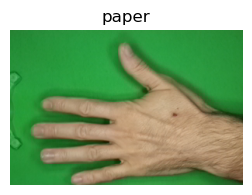

In [124]:
import cv2
import matplotlib.pyplot as plt
import random

random_idx = random.randint(0, 2187)

image = cv2.cvtColor(cv2.imread(generator.filepaths[random_idx]), cv2.COLOR_BGR2RGB)
label = [k for k, v in generator.class_indices.items() if v == generator.classes[random_idx]][0]

def show_image(image):
    plt.figure(figsize=(3, 3))
    plt.imshow(image)
    plt.title(label)
    plt.axis('off')
    plt.show()

show_image(image)

#### 2. 학습/검증/테스트 데이터(이미지) 분리 및 파일 처리
- 이미지 데이터를 분리하기 위해 각 파일의 경로와 타겟을 데이터프레임으로 만들어줍니다.

In [3]:
target_name = {v: k for k, v in generator.class_indices.items()}
target_name

{0: 'paper', 1: 'rock', 2: 'scissors'}

In [4]:
target_names = []
for target in generator.classes:
    target_names.append(target_name[target])
print(target_names.__len__())

2188


In [5]:
import pandas as pd

original_df = pd.DataFrame({'file_paths': generator.filepaths, 'target_names': target_names, 'targets': generator.classes})
original_df.loc[:, 'file_paths'] = original_df.file_paths.apply(lambda x: x.replace('\\', '/'))

display(original_df)

,file_paths,target_names,targets
0,./datasets/rock_paper_scissors/original/paper/...,paper,0
1,./datasets/rock_paper_scissors/original/paper/...,paper,0
2,./datasets/rock_paper_scissors/original/paper/...,paper,0
3,./datasets/rock_paper_scissors/original/paper/...,paper,0
4,./datasets/rock_paper_scissors/original/paper/...,paper,0
...,...,...,...
2183,./datasets/rock_paper_scissors/original/scisso...,scissors,2
2184,./datasets/rock_paper_scissors/original/scisso...,scissors,2
2185,./datasets/rock_paper_scissors/original/scisso...,scissors,2
2186,./datasets/rock_paper_scissors/original/scisso...,scissors,2


- 데이터프레임으로부터 `sklearn`의 `train_test_split()`을 사용하여 학습/검증/테스트 데이터를 분리합니다.

In [6]:
from sklearn.model_selection import train_test_split

train_images, test_images, train_targets, test_targets = \
train_test_split(original_df.file_paths, original_df.targets, stratify=original_df.targets, test_size=0.2, random_state=124)

print(train_targets.value_counts())
print(test_targets.value_counts())

targets
2    600
1    581
0    569
Name: count, dtype: int64
targets
2    150
1    145
0    143
Name: count, dtype: int64


In [7]:
train_images, validation_images, train_targets, validation_targets = \
train_test_split(train_images, train_targets, stratify=train_targets, test_size=0.2, random_state=124)

print(train_targets.value_counts())
print(validation_targets.value_counts())

targets
2    480
1    465
0    455
Name: count, dtype: int64
targets
2    120
1    116
0    114
Name: count, dtype: int64


- 분리한 데이터들을 각각 원본 데이터프레임으로부터 인덱스로 추출하여 별도의 데이터프레임으로 분리합니다.

In [8]:
train_df = original_df.iloc[train_images.index].reset_index(drop=True)
validation_df = original_df.iloc[validation_images.index].reset_index(drop=True)
test_df = original_df.iloc[test_images.index].reset_index(drop=True)

print(train_df.shape)
print(validation_df.shape)
print(test_df.shape)

(1400, 3)
(350, 3)
(438, 3)


- 실제 이미지 파일들을 학습/검증/테스트 데이터로 분리한 바에 맞게 폴더를 나누어 복사해줍니다.

In [9]:
import shutil
import os

root = './datasets/rock_paper_scissors/'

for file_path in train_images:
    rpc_dir = file_path[len(root + 'original/'): file_path.rindex('/')]
    destination = os.path.join(root, 'train/' + rpc_dir)

    if not os.path.exists(destination):
        os.makedirs(destination)

    shutil.copy2(file_path, destination)
    
for file_path in validation_images:
    rpc_dir = file_path[len(root + 'original/'): file_path.rindex('/')]
    destination = os.path.join(root, 'validation/' + rpc_dir)

    if not os.path.exists(destination):
        os.makedirs(destination)

    shutil.copy2(file_path, destination)

for file_path in test_images:
    rpc_dir = file_path[len(root + 'original/'): file_path.rindex('/')]
    destination = os.path.join(root, 'test/' + rpc_dir)

    if not os.path.exists(destination):
        os.makedirs(destination)

    shutil.copy2(file_path, destination)

#### 3. 사전 훈련 모델 학습, 예측 및 평가

- 먼저 `keras` 라이브러리의 `Sequence` 클래스를 상속 받는 `Dataset` 클래스를 만들어 이후 훈련에 활용하고자 합니다.
- 해당 클래스를 만드는 목적은 `__len__()`, `__getitem__()`, `on_epoch_end()`등의 메소드를 재정의함으로써,  
  이미지를 불러올 때 `augmentation`을 적용하거나 스케일링 관련 `preprocess function`을 적용하기 위함입니다.

In [1]:
import numpy as np
from tensorflow.keras.utils import Sequence
from sklearn.utils import shuffle
import cv2

IMAGE_SIZE = 64
BATCH_SIZE = 32

class Dataset(Sequence):
    def __init__(self, file_paths, targets, batch_size=BATCH_SIZE, aug=None, preprocess=None, shuffle=False):
        self.file_paths = file_paths
        self.targets = targets
        self.batch_size = batch_size
        self.aug = aug
        self.preprocess = preprocess
        self.shuffle = shuffle

        if self.shuffle:
            self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.targets) / self.batch_size))

    def __getitem__(self, index):
        file_paths_batch = self.file_paths[index * self.batch_size: (index + 1) * self.batch_size]
        targets_batch = self.targets[index * self.batch_size: (index + 1) * self.batch_size]

        results_batch = np.zeros((file_paths_batch.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))

        for i in range(file_paths_batch.shape[0]):
            image = cv2.cvtColor(cv2.imread(file_paths_batch[i]), cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))

            if self.aug is not None:
                image = self.aug(image=image)['image']

            if self.preprocess is not None:
                image = self.preprocess(image)

            results_batch[i] = image

        return results_batch, targets_batch

    def on_epoch_end(self):
        if self.shuffle:
            self.file_paths, self.targets = shuffle(self.file_paths, self.targets)
            

- 다음은 `create_model()` 함수를 정의합니다.
- 해당 함수의 목적은 전달 받은 사전 훈련 모델의 종류에 따라 `Convolution Backbone` 층을 알맞게 사용하고,  
  이후 훈련할 데이터의 타겟에 맞게 분류기(`Classifier Layer`)를 재정의하여 `concatenate`하기 위함입니다.

In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, Dropout, Flatten, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications import MobileNetV2

def create_model(model_name='vgg16', verbose=False):
    input_tensor = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    if model_name == 'vgg16':
        model = VGG16(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'resnet50':
        model = ResNet50V2(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'xception': 
        model = Xception(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'mobilenet':
        model = MobileNetV2(input_tensor=input_tensor, include_top=False, weights='imagenet')

    x = model.output

    # 분류기
    x = GlobalAveragePooling2D()(x)
    if model_name != 'vgg16':
        x = Dropout(rate=0.5)(x)
    x = Dense(50, activation='relu')(x)
    if model_name != 'vgg16':
        x = Dropout(rate=0.5)(x)
    output = Dense(3, activation='softmax', name='output')(x)

    model = Model(inputs=input_tensor, outputs=output)

    if verbose:
        model.summary()
    else:
        pass

    return model

#### 1) VGG16 모델
- 학습/검증/테스트 데이터의 파일 경로와 타겟 데이터를 통해 `Dataset`객체를 생성합니다.

In [101]:
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess_input

train_file_paths = train_df['file_paths'].values
train_targets = train_df['targets'].values

validation_file_paths = validation_df['file_paths'].values
validation_targets = validation_df['targets'].values

test_file_paths = test_df['file_paths'].values
test_targets = test_df['targets'].values

train_dataset = Dataset(train_file_paths, train_targets, batch_size=BATCH_SIZE, preprocess=vgg_preprocess_input, shuffle=True)
validation_dataset = Dataset(validation_file_paths, validation_targets, batch_size=BATCH_SIZE, preprocess=vgg_preprocess_input)
test_dataset = Dataset(test_file_paths, test_targets, batch_size=BATCH_SIZE, preprocess=vgg_preprocess_input)

- VGG16 사전훈련모델을 활용한 `model`객체를 생성합니다.

In [25]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

model = create_model(model_name='vgg16', verbose=True)
model.compile(optimizer=Adam(), loss=SparseCategoricalCrossentropy(), metrics=['acc'])

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 64, 64, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 64, 64, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 32, 32, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 16, 16, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 16, 16, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 16, 16, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 8, 8, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 50)                  │          25,6

 Total params: 14,740,491 (56.23 MB)

 Trainable params: 14,740,491 (56.23 MB)

 Non-trainable params: 0 (0.00 B)

- 콜백을 정의합니다.
- `ModelCheckpoint`를 통해 `epoch`마다 가중치를 파일로 내보내 저장합니다.
- `ReduceLROnPlateau`를 통해 `val_loss`의 변화에 따라 학습률을 동적으로 조정합니다.
- `EarlyStopping`을 통해 `val_loss`가 일정 `epoch` 반복 동안 감소하지 않을 경우 학습을 조기 종료합니다.

In [26]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

mcp_cb = ModelCheckpoint(
    filepath="./callback_files/rock_paper_scissors/vgg16/weights.{epoch:03d}-{val_loss:.4f}-{acc:.4f}.weights.h5",
    monitor='val_loss',
    save_best_only=False,
    save_weights_only=True,
    mode='min'
)

rlr_cb = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=2,
    mode='min'
)

ely_cb = EarlyStopping(
    monitor='val_loss',
    patience=4,
    mode='min'
)

- `gc`를 통해 메모리를 최적화한 후, `fit()`을 통해 훈련을 진행합니다.

In [27]:
import gc

gc.collect()

3573

In [28]:
N_EPOCHS = 20

history = model.fit(train_dataset,
                    batch_size=BATCH_SIZE,
                    epochs=N_EPOCHS, 
                    validation_data=validation_dataset, 
                    callbacks=[mcp_cb, rlr_cb, ely_cb])

Epoch 1/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 32s 671ms/step - acc: 0.3268 - loss: 5.1744 - val_acc: 0.3429 - val_loss: 1.1047 - learning_rate: 0.0010
Epoch 2/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 34s 758ms/step - acc: 0.3388 - loss: 1.1626 - val_acc: 0.3429 - val_loss: 1.0921 - learning_rate: 0.0010
Epoch 3/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 33s 752ms/step - acc: 0.4837 - loss: 1.0514 - val_acc: 0.7629 - val_loss: 0.5738 - learning_rate: 0.0010
Epoch 4/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 33s 755ms/step - acc: 0.7837 - loss: 0.5667 - val_acc: 0.7429 - val_loss: 0.6446 - learning_rate: 0.0010
Epoch 5/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 33s 754ms/step - acc: 0.8045 - loss: 0.4772 - val_acc: 0.9486 - val_loss: 0.1180 - learning_rate: 0.0010
Epoch 6/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 35s 793ms/step - acc: 0.9557 - loss: 0.1211 - val_acc: 0.9743 - val_loss: 0.0854 - learning_rate: 0.0010
Epoch 7/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 33s 753ms/step - acc: 0.9760 - loss: 0.0795 - val_acc: 0.9943 - val_loss: 0.0184 - learning_rate: 0.0010

- `Epoch 12`에서 검증 데이터에 대한 `loss` 값이 가장 낮았으므로, 해당 가중치를 불러와 사용합니다.

In [29]:
model.load_weights('./callback_files/rock_paper_scissors/vgg16/weights.012-0.0135-0.9986.weights.h5')

- `evaluate()`을 통해 테스트 데이터에 대한 예측을 평가하고,  
  학습 데이터에 대한 정확도와 검증 데이터에 대한 정확도의 변화를 시각화합니다.

In [30]:
model.evaluate(test_dataset)

14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - acc: 0.9899 - loss: 0.0288


[0.025793466717004776, 0.990867555141449]

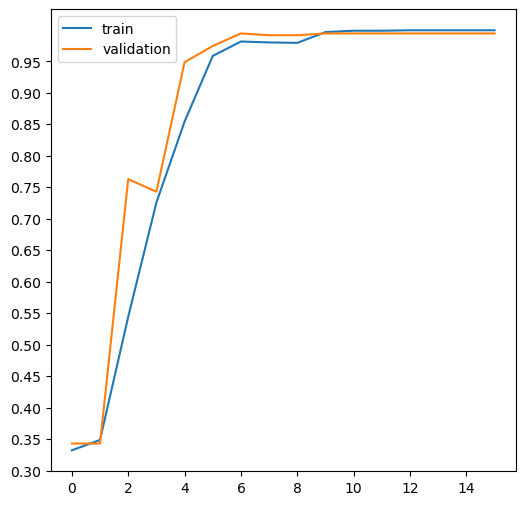

In [31]:
import matplotlib.pyplot as plt

def show_history(history):
    plt.figure(figsize=(6, 6))
    plt.yticks(np.arange(0, 1, 0.05))
    plt.plot(history.history['acc'], label='train')
    plt.plot(history.history['val_acc'], label='validation')
    plt.legend()
    plt.show()

show_history(history)

#### 2) Xception 모델
- 이하 과정은 vgg16 모델과 동일하므로, 앞으로의 사전훈련모델 사용 부분에서는 코드에 대한 설명을 생략합니다.

In [32]:
from tensorflow.keras.applications.xception import preprocess_input as xception_preprocess_input

train_file_paths = train_df['file_paths'].values
train_targets = train_df['targets'].values

validation_file_paths = validation_df['file_paths'].values
validation_targets = validation_df['targets'].values

test_file_paths = test_df['file_paths'].values
test_targets = test_df['targets'].values

train_dataset = Dataset(train_file_paths, train_targets, batch_size=BATCH_SIZE, preprocess=xception_preprocess_input, shuffle=True)
validation_dataset = Dataset(validation_file_paths, validation_targets, batch_size=BATCH_SIZE, preprocess=xception_preprocess_input)
test_dataset = Dataset(test_file_paths, test_targets, batch_size=BATCH_SIZE, preprocess=xception_preprocess_input)

In [33]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

model = create_model(model_name='xception', verbose=True)
model.compile(optimizer=Adam(), loss=SparseCategoricalCrossentropy(), metrics=['acc'])

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)    │ (None, 64, 64, 3)         │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1_conv1 (Conv2D)         │ (None, 31, 31, 32)        │             864 │ input_layer_3[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1_conv1_bn               │ (None, 31, 31, 32)        │             128 │ block1_conv1[0][0]         │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1_conv1_act (Activation) │ (None, 31, 31, 32)        │               0 │ block1_conv1_bn[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1_conv2 (Conv2D)         │ (None, 29, 29, 64)        │          18,432 │ block1_conv1_act[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1_conv2_bn               │ (None, 29, 29, 64)        │             256 │ block1_conv2[0][0]         │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1_conv2_act (Activation) │ (None, 29, 29, 64)        │               0 │ block1_conv2_bn[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2_sepconv1               │ (None, 29, 29, 128)       │           8,768 │ block1_conv2_act[0][0]     │
│ (SeparableConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2_sepconv1_bn            │ (None, 29, 29, 128)       │             512 │ block2_sepconv1[0][0]      │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2_sepconv2_act           │ (None, 29, 29, 128)       │               0 │ block2_sepconv1_bn[0][0]   │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2_sepconv2               │ (None, 29, 29, 128)       │          17,536 │ block2_sepconv2_act[0][0]  │
│ (SeparableConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2_sepconv2_bn            │ (None, 29, 29, 128)       │             512 │ block2_sepconv2[0][0]      │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d (Conv2D)               │ (None, 15, 15, 128)       │           8,192 │ block1_conv2_act[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2_pool (MaxPooling2D)    │ (None, 15, 15, 128)       │               

 Total params: 20,964,083 (79.97 MB)

 Trainable params: 20,909,555 (79.76 MB)

 Non-trainable params: 54,528 (213.00 KB)

In [34]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

mcp_cb = ModelCheckpoint(
    filepath="./callback_files/rock_paper_scissors/xception/weights.{epoch:03d}-{val_loss:.4f}-{acc:.4f}.weights.h5",
    monitor='val_loss',
    save_best_only=False,
    save_weights_only=True,
    mode='min'
)

rlr_cb = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=2,
    mode='min'
)

ely_cb = EarlyStopping(
    monitor='val_loss',
    patience=4,
    mode='min'
)

In [35]:
import gc

gc.collect()

6625

In [36]:
N_EPOCHS = 20

history = model.fit(train_dataset,
                    batch_size=BATCH_SIZE,
                    epochs=N_EPOCHS, 
                    validation_data=validation_dataset, 
                    callbacks=[mcp_cb, rlr_cb, ely_cb])

Epoch 1/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 34s 386ms/step - acc: 0.6907 - loss: 0.8463 - val_acc: 0.7114 - val_loss: 1.1298 - learning_rate: 0.0010
Epoch 2/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 18s 390ms/step - acc: 0.9457 - loss: 0.3818 - val_acc: 0.9486 - val_loss: 0.1941 - learning_rate: 0.0010
Epoch 3/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 18s 399ms/step - acc: 0.9893 - loss: 0.1096 - val_acc: 1.0000 - val_loss: 0.0018 - learning_rate: 0.0010
Epoch 4/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 18s 403ms/step - acc: 0.9900 - loss: 0.0645 - val_acc: 0.9971 - val_loss: 0.0367 - learning_rate: 0.0010
Epoch 5/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 32s 736ms/step - acc: 0.9874 - loss: 0.0524 - val_acc: 1.0000 - val_loss: 4.2469e-07 - learning_rate: 0.0010
Epoch 6/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 33s 738ms/step - acc: 0.9941 - loss: 0.0212 - val_acc: 1.0000 - val_loss: 0.0014 - learning_rate: 0.0010
Epoch 7/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 27s 615ms/step - acc: 0.9808 - loss: 0.0681 - val_acc: 1.0000 - val_loss: 7.5645e-04 - learning_rate

- `VGG16` 모델과 마찬가지로, 이전 `Epoch`(`Epoch 5`)에서의 검증 데이터 `loss`가 가장 낮았으므로,  
  해당 가중치를 불러와 사용합니다.

In [37]:
model.load_weights('./callback_files/rock_paper_scissors/xception/weights.005-0.0000-0.9829.weights.h5')

In [38]:
model.evaluate(test_dataset)

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - acc: 0.9960 - loss: 0.0632


[0.07371947914361954, 0.9954338073730469]

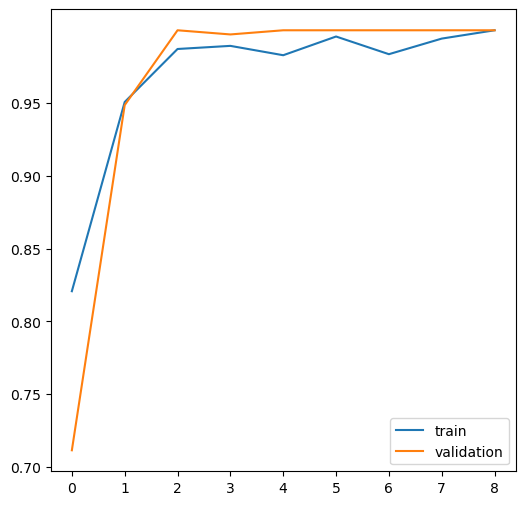

In [39]:
import matplotlib.pyplot as plt

def show_history(history):
    plt.figure(figsize=(6, 6))
    plt.yticks(np.arange(0, 1, 0.05))
    plt.plot(history.history['acc'], label='train')
    plt.plot(history.history['val_acc'], label='validation')
    plt.legend()
    plt.show()

show_history(history)

#### 3) ResNet50 모델

In [40]:
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess_input

train_file_paths = train_df['file_paths'].values
train_targets = train_df['targets'].values

validation_file_paths = validation_df['file_paths'].values
validation_targets = validation_df['targets'].values

test_file_paths = test_df['file_paths'].values
test_targets = test_df['targets'].values

train_dataset = Dataset(train_file_paths, train_targets, batch_size=BATCH_SIZE, preprocess=resnet_preprocess_input, shuffle=True)
validation_dataset = Dataset(validation_file_paths, validation_targets, batch_size=BATCH_SIZE, preprocess=resnet_preprocess_input)
test_dataset = Dataset(test_file_paths, test_targets, batch_size=BATCH_SIZE, preprocess=resnet_preprocess_input)

In [41]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

model = create_model(model_name='resnet50', verbose=True)
model.compile(optimizer=Adam(), loss=SparseCategoricalCrossentropy(), metrics=['acc'])

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)    │ (None, 64, 64, 3)         │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_pad (ZeroPadding2D)     │ (None, 70, 70, 3)         │               0 │ input_layer_4[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_conv (Conv2D)           │ (None, 32, 32, 64)        │           9,472 │ conv1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pad (ZeroPadding2D)     │ (None, 34, 34, 64)        │               0 │ conv1_conv[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pool (MaxPooling2D)     │ (None, 16, 16, 64)        │               0 │ pool1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_preact_bn        │ (None, 16, 16, 64)        │             256 │ pool1_pool[0][0]           │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_preact_relu      │ (None, 16, 16, 64)        │               0 │ conv2_block1_preact_bn[0]… │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_conv (Conv2D)  │ (None, 16, 16, 64)        │           4,096 │ conv2_block1_preact_relu[… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_bn             │ (None, 16, 16, 64)        │             256 │ conv2_block1_1_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_relu           │ (None, 16, 16, 64)        │               0 │ conv2_block1_1_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_pad            │ (None, 18, 18, 64)        │               0 │ conv2_block1_1_relu[0][0]  │
│ (ZeroPadding2D)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_conv (Conv2D)  │ (None, 16, 16, 64)        │          36,864 │ conv2_block1_2_pad[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_bn             │ (None, 16, 16, 64)        │             256 │ conv2_block1_2_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_relu           │ (None, 16, 16, 64)        │               0 │ conv2_block1_2_bn[0][0]    │
│ (Activation)                  │                           │               

 Total params: 23,667,403 (90.28 MB)

 Trainable params: 23,621,963 (90.11 MB)

 Non-trainable params: 45,440 (177.50 KB)

In [42]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

mcp_cb = ModelCheckpoint(
    filepath="./callback_files/rock_paper_scissors/resnet50/weights.{epoch:03d}-{val_loss:.4f}-{acc:.4f}.weights.h5",
    monitor='val_loss',
    save_best_only=False,
    save_weights_only=True,
    mode='min'
)

rlr_cb = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=2,
    mode='min'
)

ely_cb = EarlyStopping(
    monitor='val_loss',
    patience=4,
    mode='min'
)

In [43]:
import gc

gc.collect()

967

In [44]:
N_EPOCHS = 20

history = model.fit(train_dataset,
                    batch_size=BATCH_SIZE,
                    epochs=N_EPOCHS, 
                    validation_data=validation_dataset, 
                    callbacks=[mcp_cb, rlr_cb, ely_cb])

Epoch 1/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 37s 375ms/step - acc: 0.6880 - loss: 0.7769 - val_acc: 0.3314 - val_loss: 87.8824 - learning_rate: 0.0010
Epoch 2/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 20s 440ms/step - acc: 0.9906 - loss: 0.0492 - val_acc: 0.8257 - val_loss: 4.9400 - learning_rate: 0.0010
Epoch 3/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 24s 549ms/step - acc: 0.9949 - loss: 0.0170 - val_acc: 1.0000 - val_loss: 0.0019 - learning_rate: 0.0010
Epoch 4/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 25s 556ms/step - acc: 0.9945 - loss: 0.0115 - val_acc: 0.9943 - val_loss: 0.0261 - learning_rate: 0.0010
Epoch 5/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 25s 556ms/step - acc: 0.9809 - loss: 0.0839 - val_acc: 0.9829 - val_loss: 0.1226 - learning_rate: 0.0010
Epoch 6/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 25s 559ms/step - acc: 0.9984 - loss: 0.0091 - val_acc: 1.0000 - val_loss: 0.0014 - learning_rate: 1.0000e-04
Epoch 7/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 22s 504ms/step - acc: 0.9980 - loss: 0.0101 - val_acc: 1.0000 - val_loss: 0.0011 - learning_rate: 1

- `VGG16` 및 `Xception` 모델과 마찬가지로, 이전 `Epoch`(`Epoch 8`)에서의 검증 데이터 `loss`가 가장 낮았으므로,  
  해당 가중치를 불러와 사용합니다.

In [45]:
model.load_weights('./callback_files/rock_paper_scissors/resnet50/weights.008-0.0010-1.0000.weights.h5')

In [46]:
model.evaluate(test_dataset)

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - acc: 0.9990 - loss: 0.0029


[0.005067631136626005, 0.9977169036865234]

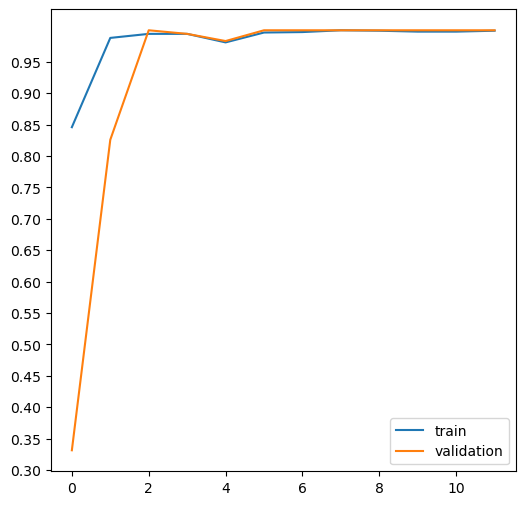

In [47]:
import matplotlib.pyplot as plt

def show_history(history):
    plt.figure(figsize=(6, 6))
    plt.yticks(np.arange(0, 1, 0.05))
    plt.plot(history.history['acc'], label='train')
    plt.plot(history.history['val_acc'], label='validation')
    plt.legend()
    plt.show()

show_history(history)

#### 4) MobileNetV2 모델

In [59]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess_input

train_file_paths = train_df['file_paths'].values
train_targets = train_df['targets'].values

validation_file_paths = validation_df['file_paths'].values
validation_targets = validation_df['targets'].values

test_file_paths = test_df['file_paths'].values
test_targets = test_df['targets'].values

train_dataset = Dataset(train_file_paths, train_targets, batch_size=BATCH_SIZE, preprocess=mobilenet_preprocess_input, shuffle=True)
validation_dataset = Dataset(validation_file_paths, validation_targets, batch_size=BATCH_SIZE, preprocess=mobilenet_preprocess_input)
test_dataset = Dataset(test_file_paths, test_targets, batch_size=BATCH_SIZE, preprocess=mobilenet_preprocess_input)

In [60]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

model = create_model(model_name='mobilenet', verbose=True)
model.compile(optimizer=Adam(), loss=SparseCategoricalCrossentropy(), metrics=['acc'])

C:\Users\hyuns\AppData\Local\Temp\ipykernel_31624\2144017258.py:17: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  model = MobileNetV2(input_tensor=input_tensor, include_top=False, weights='imagenet')


Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)    │ (None, 64, 64, 3)         │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1 (Conv2D)                │ (None, 32, 32, 32)        │             864 │ input_layer_7[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bn_Conv1 (BatchNormalization) │ (None, 32, 32, 32)        │             128 │ Conv1[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1_relu (ReLU)             │ (None, 32, 32, 32)        │               0 │ bn_Conv1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise       │ (None, 32, 32, 32)        │             288 │ Conv1_relu[0][0]           │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_BN    │ (None, 32, 32, 32)        │             128 │ expanded_conv_depthwise[0… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_relu  │ (None, 32, 32, 32)        │               0 │ expanded_conv_depthwise_B… │
│ (ReLU)                        │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project         │ (None, 32, 32, 16)        │             512 │ expanded_conv_depthwise_r… │
│ (Conv2D)                      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project_BN      │ (None, 32, 32, 16)        │              64 │ expanded_conv_project[0][… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand (Conv2D)       │ (None, 32, 32, 96)        │           1,536 │ expanded_conv_project_BN[… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_BN             │ (None, 32, 32, 96)        │             384 │ block_1_expand[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_relu (ReLU)    │ (None, 32, 32, 96)        │               0 │ block_1_expand_BN[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_pad (ZeroPadding2D)   │ (None, 33, 33, 96)        │               0 │ block_1_expand_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_depthwise             │ (None, 16, 16, 96)        │             864 │ block_1_pad[0][0]          │
│ (DepthwiseConv2D)             │                           │               

 Total params: 2,322,187 (8.86 MB)

 Trainable params: 2,288,075 (8.73 MB)

 Non-trainable params: 34,112 (133.25 KB)

- `MobileNetV2` 모델의 경우 `val_loss` 수치가 불안정한 문제가 있어, `EarlyStopping`의 `patience`를 조정하여 학습 경과를 지켜보고자 했습니다.
- 또한 `Epoch` 수를 30까지 증가시켜봅니다.

In [61]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

mcp_cb = ModelCheckpoint(
    filepath="./callback_files/rock_paper_scissors/mobilenet/weights.{epoch:03d}-{val_loss:.4f}-{acc:.4f}.weights.h5",
    monitor='val_loss',
    save_best_only=False,
    save_weights_only=True,
    mode='min'
)

rlr_cb = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=2,
    mode='min'
)

ely_cb = EarlyStopping(
    monitor='val_loss',
    patience=8,
    mode='min'
)

In [62]:
import gc

gc.collect()

40989

In [63]:
N_EPOCHS = 30

history = model.fit(train_dataset,
                    batch_size=BATCH_SIZE,
                    epochs=N_EPOCHS, 
                    validation_data=validation_dataset, 
                    callbacks=[mcp_cb, rlr_cb, ely_cb])

Epoch 1/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 25s 185ms/step - acc: 0.6614 - loss: 1.0441 - val_acc: 0.9257 - val_loss: 0.4654 - learning_rate: 0.0010
Epoch 2/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 8s 178ms/step - acc: 0.9616 - loss: 0.1224 - val_acc: 0.9857 - val_loss: 0.0773 - learning_rate: 0.0010
Epoch 3/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 8s 179ms/step - acc: 0.9854 - loss: 0.0640 - val_acc: 0.9800 - val_loss: 0.1501 - learning_rate: 0.0010
Epoch 4/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 8s 182ms/step - acc: 0.9908 - loss: 0.0592 - val_acc: 1.0000 - val_loss: 8.5316e-07 - learning_rate: 0.0010
Epoch 5/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 9s 185ms/step - acc: 0.9939 - loss: 0.0361 - val_acc: 0.9886 - val_loss: 0.1242 - learning_rate: 0.0010
Epoch 6/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 9s 191ms/step - acc: 0.9943 - loss: 0.0344 - val_acc: 0.7914 - val_loss: 4.8031 - learning_rate: 0.0010
Epoch 7/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 9s 193ms/step - acc: 0.9976 - loss: 0.0102 - val_acc: 0.8714 - val_loss: 2.7357 - learning_rate: 1.0000e-

- `VGG16`, `Xception`, `ResNet50` 모델과 마찬가지로, 이전 `Epoch`(`Epoch 4`)에서의 검증 데이터 `loss`가 가장 낮았으므로,  
  해당 가중치를 불러와 사용합니다.

In [64]:
model.load_weights('./callback_files/rock_paper_scissors/mobilenet/weights.004-0.0000-0.9900.weights.h5')

In [65]:
model.evaluate(test_dataset)

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - acc: 0.9950 - loss: 0.0666


[0.07787362486124039, 0.9931507110595703]

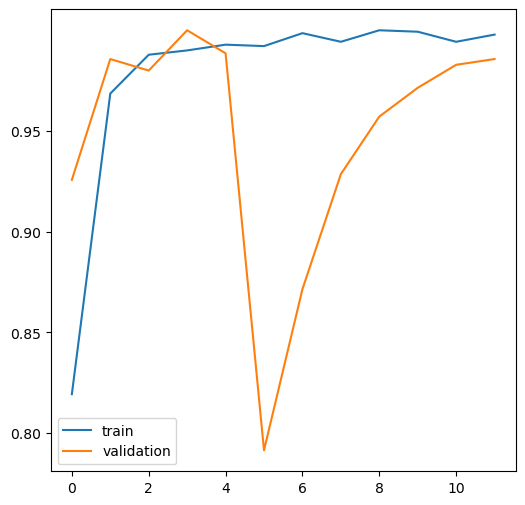

In [66]:
import matplotlib.pyplot as plt

def show_history(history):
    plt.figure(figsize=(6, 6))
    plt.yticks(np.arange(0, 1, 0.05))
    plt.plot(history.history['acc'], label='train')
    plt.plot(history.history['val_acc'], label='validation')
    plt.legend()
    plt.show()

show_history(history)

#### 4. 모델별 예측 정확도 비교

- 각 사전훈련모델 별 학습 데이터에서의 정확도와 검증 데이터에서의 정확도,  
  그리고 `evaluate()`를 통한 테스트 데이터에서의 예측 정확도는 아래와 같습니다.

#### 1. VGG16 모델

**Epoch 12/20**
- train_acc: 0.9998, train_loss: 0.0032, val_acc: 0.9943, val_loss: 0.0135
- test_acc: 0.9899, test_loss: 0.0288

#### 2. Xception 모델

**Epoch 5/20**
- train_acc: 0.9874, train_loss: 0.0524, val_acc: 1.0000, val_loss: 4.2469e-07
- test_acc: 0.9960, test_loss: 0.0632

#### 3. ResNet50 모델

**Epoch 8/20**
- train_acc: 1.0000, train_loss: 0.0094, val_acc: 1.0000, val_loss: 9.6921e-04
- test_acc: 0.9990, test_loss: 0.0029

#### 4. MobileNetV2 모델

**Epoch 4/20**
- train_acc: 0.9908, train_loss: 0.0592, val_acc: 1.0000, val_loss: 8.5316e-07
- test_acc: 0.9950, test_loss: 0.0666

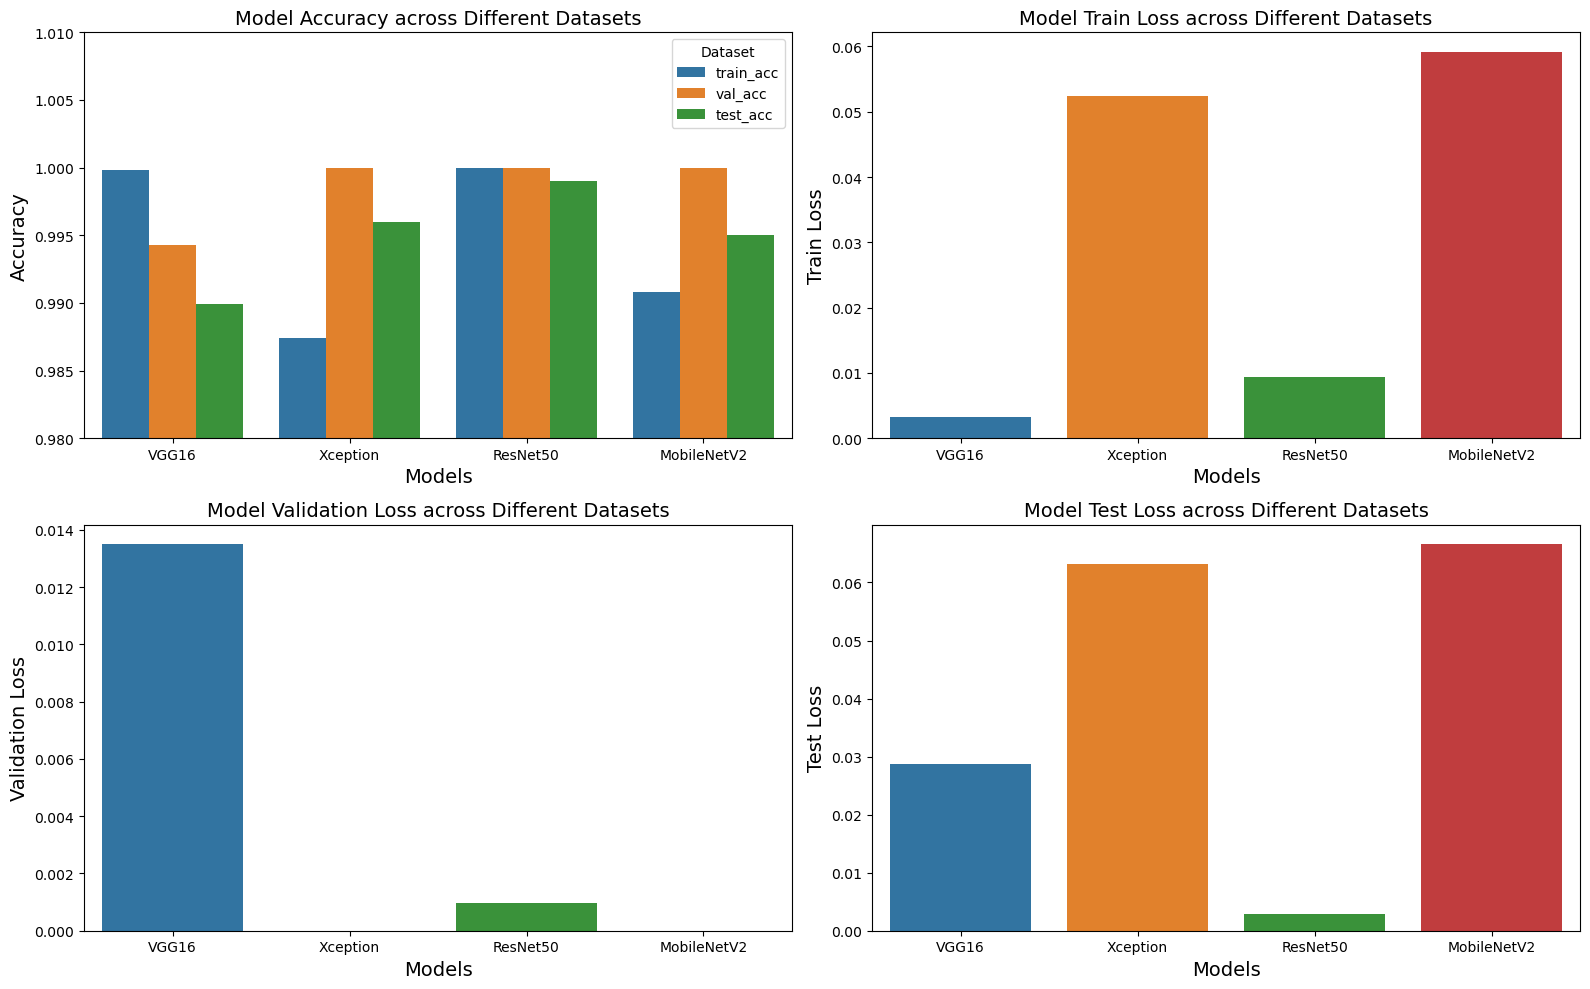

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

score_df = pd.DataFrame({
    'Models': ['VGG16', 'Xception', 'ResNet50', 'MobileNetV2'],
    'train_acc': [0.9998, 0.9874, 1.0000, 0.9908],
    'val_acc': [0.9943, 1.0000, 1.0000, 1.0000],
    'test_acc': [0.9899, 0.9960, 0.9990, 0.9950],
    'train_loss': [0.0032, 0.0524, 0.0094, 0.0592],
    'val_loss': [0.0135, 4.2469e-7, 9.6921e-4, 8.5316e-7],
    'test_loss': [0.0288, 0.0632, 0.0029, 0.0666]
})

acc_df = score_df.melt(id_vars='Models', value_vars=['train_acc', 'val_acc', 'test_acc'], var_name='Dataset', value_name='Accuracy')
loss_df = score_df.melt(id_vars='Models', value_vars=['train_loss', 'val_loss', 'test_loss'], var_name='Dataset', value_name='Loss')

fig, axs = plt.subplots(2, 2, figsize=(16, 10))
axs = axs.flatten()

sns.barplot(x='Models', y='Accuracy', hue='Dataset', data=acc_df, ax=axs[0])
axs[0].set_title('Model Accuracy across Different Datasets', fontsize=14)
axs[0].set_xlabel('Models', fontsize=14)
axs[0].set_ylabel('Accuracy', fontsize=14)
axs[0].set_ylim(0.98, 1.01)

sns.barplot(x='Models', y='train_loss', data=score_df, ax=axs[1])
axs[1].set_title('Model Train Loss across Different Datasets', fontsize=14)
axs[1].set_xlabel('Models', fontsize=14)
axs[1].set_ylabel('Train Loss', fontsize=14)

sns.barplot(x='Models', y='val_loss', data=score_df, ax=axs[2])
axs[2].set_title('Model Validation Loss across Different Datasets', fontsize=14)
axs[2].set_xlabel('Models', fontsize=14)
axs[2].set_ylabel('Validation Loss', fontsize=14)

sns.barplot(x='Models', y='test_loss', data=score_df, ax=axs[3])
axs[3].set_title('Model Test Loss across Different Datasets', fontsize=14)
axs[3].set_xlabel('Models', fontsize=14)
axs[3].set_ylabel('Test Loss', fontsize=14)

plt.tight_layout()
plt.show()

#### 5. 실제 이미지에 대한 예측 수행

- 테스트 데이터에서의 정확도가 가장 높았던 `ResNet50` 모델과, 학습 데이터에서의 `loss`가 가장 낮았던 `VGG16` 모델을 통해,  
  데이터셋에 없었던 실제 가위바위보 이미지를 얼마나 잘 예측하는지 테스트해보고자 합니다.

In [10]:
temp_vgg = create_model(model_name='vgg16', verbose=False)
# temp_model.compile(optimizer=Adam(), loss=SparseCategoricalCrossentropy(), metrics=['acc'])
temp_vgg.load_weights('./callback_files/rock_paper_scissors/vgg16/weights.012-0.0135-0.9986.weights.h5')

temp_resnet = create_model(model_name='resnet50', verbose=False)
temp_resnet.load_weights('./callback_files/rock_paper_scissors/resnet50/weights.008-0.0010-1.0000.weights.h5')

In [4]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess_input
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess_input
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobile_preprocess_input
from tensorflow.keras.applications.xception import preprocess_input as xception_preprocess_input

def get_prediction(image, model2, preprocess):
    
    image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
    image = preprocess(image)
    image = img_to_array(image)
    
    image = np.expand_dims(image, axis=0)
    prediction = model2.predict(image)
    print(prediction[0])
    predicted_class_index = np.argmax(prediction, axis=1)
    
    return predicted_class_index

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
[1.1610737e-01 5.4927886e-04 8.8334340e-01]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
[0.04071542 0.00928012 0.95000446]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
[9.9999642e-01 1.1723301e-07 3.5147439e-06]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
[0.7454453  0.06657791 0.18797676]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
[0.8128539  0.00256936 0.18457669]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
[0.17577176 0.6921179  0.13211027]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
[0.13762172 0.36259502 0.49978325]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
[0.2545391  0.07494519 0.6705158 ]


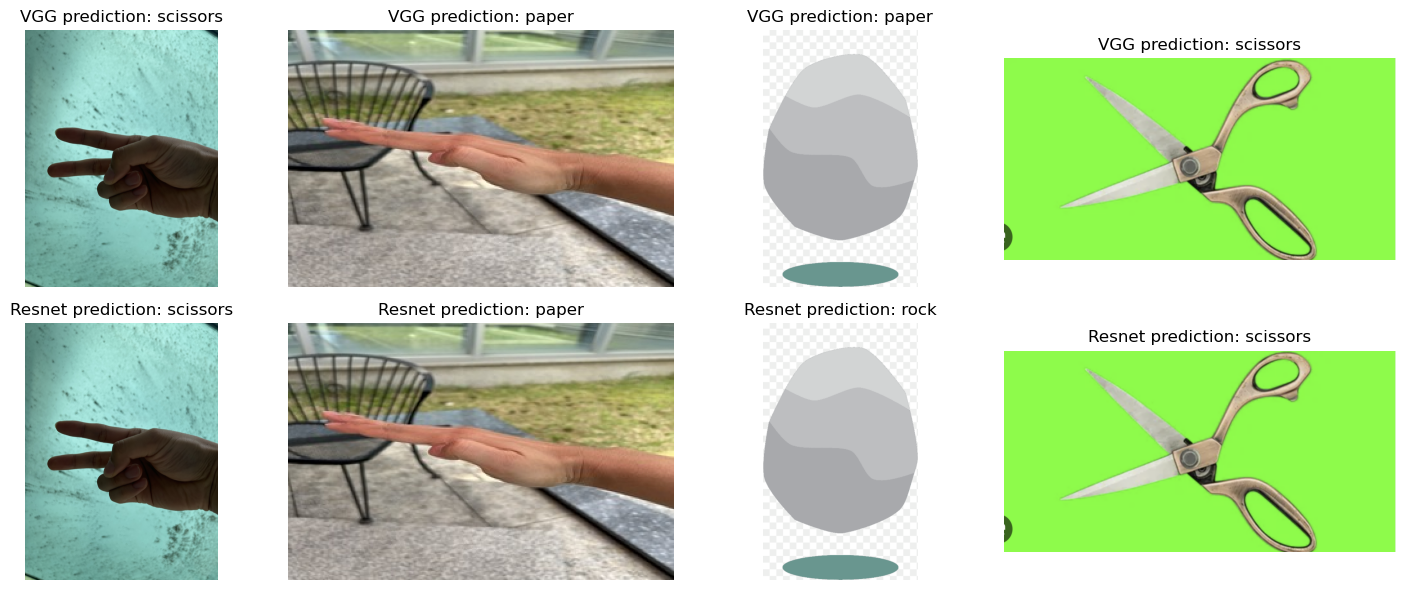

In [35]:
import numpy as np

image1 = cv2.imread('./datasets/rock_paper_scissors/custom_images/scissors/custom_scissors3.jpg')
image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)

image2 = cv2.imread('./datasets/rock_paper_scissors/custom_images/paper/custom_paper2.jpg')
image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)

image3 = cv2.imread('./datasets/rock_paper_scissors/custom_images/rock/custom_rock3.png')
image3 = cv2.cvtColor(image3, cv2.COLOR_BGR2RGB)

image4 = cv2.imread('./datasets/rock_paper_scissors/custom_images/scissors/custom_scissors4.png')
image4 = cv2.cvtColor(image4, cv2.COLOR_BGR2RGB)

vgg_prediction1 = get_prediction(image1, temp_vgg, vgg_preprocess_input)
resnet_prediction1 = get_prediction(image1, temp_resnet, resnet_preprocess_input)

vgg_prediction2 = get_prediction(image2, temp_vgg, vgg_preprocess_input)
resnet_prediction2 = get_prediction(image2, temp_resnet, resnet_preprocess_input)

vgg_prediction3 = get_prediction(image3, temp_vgg, vgg_preprocess_input)
resnet_prediction3 = get_prediction(image3, temp_resnet, resnet_preprocess_input)

vgg_prediction4 = get_prediction(image4, temp_vgg, vgg_preprocess_input)
resnet_prediction4 = get_prediction(image4, temp_resnet, resnet_preprocess_input)

labels = ['paper', 'rock', 'scissors']

fig, axs = plt.subplots(2, 4, figsize=(15, 6))
axs = axs.flatten()
for i in range(8):
    axs[i].axis('off')
axs[0].imshow(image1)
axs[0].set_title(f'VGG prediction: {labels[vgg_prediction1[0]]}')
axs[4].imshow(image1)
axs[4].set_title(f'Resnet prediction: {labels[resnet_prediction1[0]]}')

axs[1].imshow(image2)
axs[1].set_title(f'VGG prediction: {labels[vgg_prediction2[0]]}')
axs[5].imshow(image2)
axs[5].set_title(f'Resnet prediction: {labels[resnet_prediction2[0]]}')

axs[2].imshow(image3)
axs[2].set_title(f'VGG prediction: {labels[vgg_prediction3[0]]}')
axs[6].imshow(image3)
axs[6].set_title(f'Resnet prediction: {labels[resnet_prediction3[0]]}')

axs[3].imshow(image4)
axs[3].set_title(f'VGG prediction: {labels[vgg_prediction4[0]]}')
axs[7].imshow(image4)
axs[7].set_title(f'Resnet prediction: {labels[resnet_prediction4[0]]}')


plt.tight_layout()
plt.show()

- 조금 어두운 가위 사진에 대해서는 VGG16과 ResNet50 모두 '가위'로 정확히 예측했습니다.
- 손바닥의 측면에서 찍은 사진에 대해서도 VGG16과 ResNet50 모두 '보'로 정확히 예측했습니다.
- 심지어 '주먹' 사진이 아닌 말 그대로 'rock(바위)' 이미지에 대해서도 ResNet50은 '주먹'으로 예측했으나,  
  VGG16은 예측하지 못했습니다.
- 한편 실제 '가위' 사진에 대해서는 두 모델 모두 정확히 '가위'로 예측했습니다.

#### 6. 🚩느낀 점

- 4가지 사전훈련모델을 활용하여 '가위', '바위', '보' 이미지에 대한 분류 예측을 수행한 결과,  
  학습/검증/테스트 데이터 모두에서 가장 높은 정확도(accuracy)를 보인 모델은 `ResNet50` 모델이었으며,  
  `VGG16` 모델은 정확도 측면에서는 보다 낮았지만 학습 데이터에서의 `loss` 값이 가장 낮게 나타났습니다.
- 의류 이미지 분류 프로젝트에서도 확인할 수 있었듯, 비교적 단순한 층으로 구성된 `VGG16` 모델임에도 불구하고  
  보다 복잡한 `ResNet50` 모델보다 학습 데이터에서 `loss` 값이 낮게 나타났다는 사실이 놀라웠습니다.
- 또한 학습 Epoch 마다 학습/검증 데이터에서의 정확도를 시각화한 결과, `MobileNetV2` 모델에서 특히 검증 데이터 정확도가 큰 변동을 보였습니다.
- 사전 훈련 모델의 `Convolutional Backbone`을 사용하고, `Classifier Layer`만을 재정의하였음에도 불구하고,  
  전반적으로 학습/검증/테스트 데이터에서의 정확도 모두 1.0에 가까운 높은 수치를 보였다는 점에서,  
  이미지 데이터의 크기와 종류에 따라 적절한 사전 훈련 모델을 활용하는 것이 매우 효과적이라는 사실을 다시금 깨달을 수 있었습니다.